In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Preprocessing

In [79]:
data = pd.read_csv('merc.csv')
for i in data.columns:
  print(i)

model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize


In [80]:
data.pop("model") #remove non-relevant columns
data.pop("transmission")
data.pop("fuelType")

0        Petrol
1        Hybrid
2        Petrol
3        Petrol
4        Petrol
          ...  
13114    Diesel
13115    Diesel
13116    Diesel
13117    Diesel
13118    Diesel
Name: fuelType, Length: 13119, dtype: object

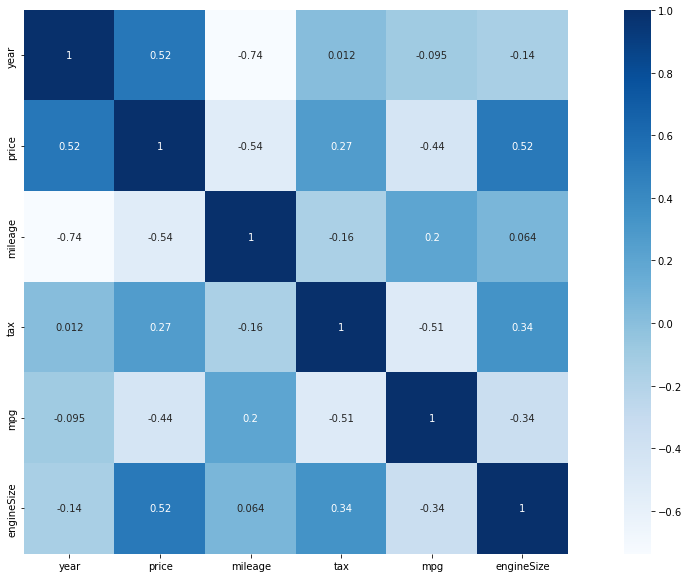

In [81]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), square=True, annot=True, cmap="Blues");

In [82]:
data

,year,price,mileage,tax,mpg,engineSize
0,2005,5200,63000,325,32.1,1.8
1,2017,34948,27000,20,61.4,2.1
2,2016,49948,6200,555,28.0,5.5
3,2016,61948,16000,325,30.4,4.0
4,2016,73948,4000,325,30.1,4.0
...,...,...,...,...,...,...
13114,2020,35999,500,145,55.4,2.0
13115,2020,24699,2500,145,55.4,2.0
13116,2019,30999,11612,145,41.5,2.1
13117,2019,37990,2426,145,45.6,2.0


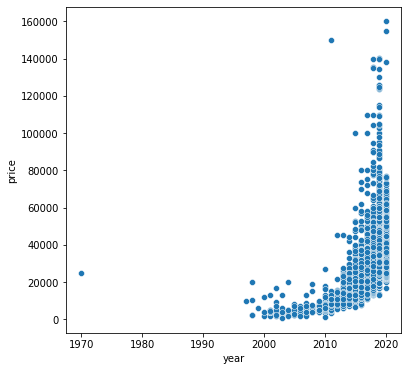

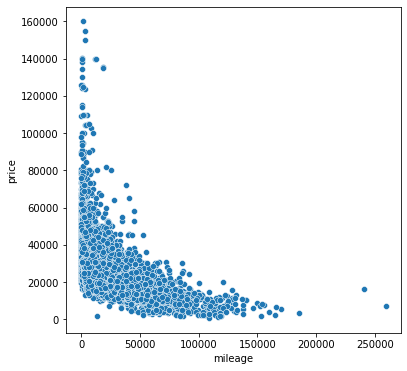

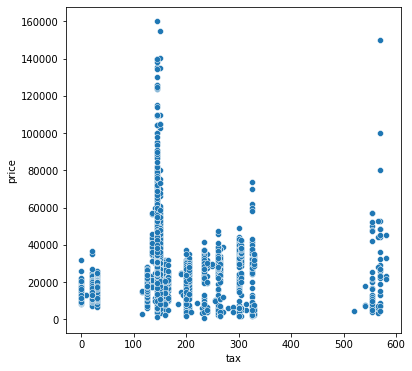

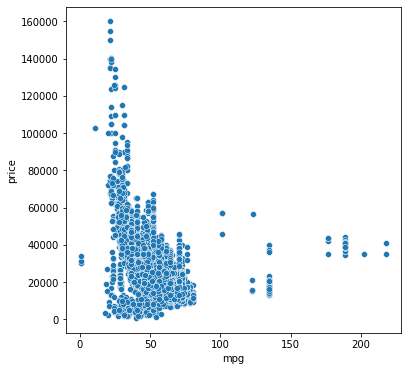

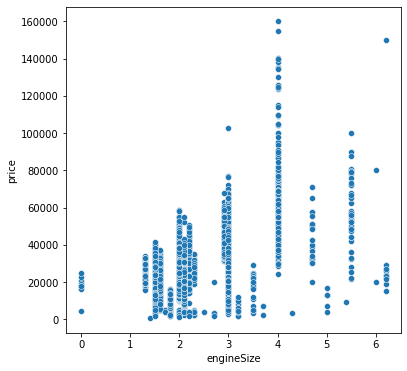

In [83]:
Y = data.pop("price")

cols = [col for col in data.columns if data[col].dtype in ['int64','float64']]

for idx, col in enumerate(cols):
    plt.figure(idx, figsize=(6,6))
    sns.scatterplot(x=col, y=Y, data=data)
    plt.show

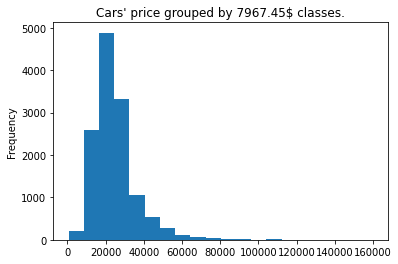

In [84]:
#Plot of the distribution
prices = Y
bins = 20
class_size = (max(prices) - min(prices))/bins
prices.plot.hist(bins=20)
plt.title("Cars' price grouped by {:.2f}$ classes.".format(class_size))
plt.savefig('Price distribution.png')
plt.show()

In [85]:
Y = Y.to_numpy()
X = data.to_numpy()

In [86]:
scaler = StandardScaler()
scaler.fit(Y.reshape((-1,1)))
Y = scaler.transform(Y.reshape((-1,1)))
Y = Y.reshape(-1)

scaler.fit(X)
X = scaler.transform(X)

In [87]:
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.33)
print(X.shape, X_test.shape)

(8789, 5) (4330, 5)


# Gradient Descent & Others Methods

In [88]:
def predict(X, W, b):
    return X.dot(W) + b

def l2_loss(X, Y, W, b, lbda):
  m = X.shape[0]
  error = predict(X, W, b) - Y
  return 0.5/m * np.sum(error**2) + 0.5*lbda*np.linalg.norm(W)**2

def gradient(X, Y, W, b, lbda):
  pred = predict(X, W, b)
  n = X.shape[0]
  dw = X.T.dot(pred - Y)/n + lbda*W
  db = 2/n * np.sum(pred - Y)
  #print(dw, db)
  return dw, db

def gradient_i(X, Y, W, b, lbda):
  pred = predict(X, W, b)
  n = X.shape[0]
  dw = X*(pred - Y)/n + lbda*W
  db = 2/n * np.sum(pred - Y)
  #print(dw, db)
  return dw, db

def evaluate(X,Y,W,b):
  losses = l2_loss(X, Y, W, b, lbda=0)
  return losses, np.mean(losses)

def batch_gradient_descent(X, Y, epochs, batchSize, alpha, stepChoice=0, gamma=0, scaling=0, lbda = 0, fixed_seed=False, X_test=None, Y_test=None):
  if fixed_seed:
    np.random.seed(1)
  update_old_w, update_old_b = 0, 0
  n, m = X.shape
  W = np.random.rand(m)
  b = np.random.rand(1)
  losses = []
  val_losses=[]

  #Scaling values
  if scaling>0:
      mu=1/(2 *(n ** (0.5)))
      v = np.zeros(m)
      beta = 0.8

  for i in range(epochs):
    if batchSize != n : 
      ik = np.random.choice(n, batchSize, replace=False)
      sgw = np.zeros(m)
      sgb = np.zeros(1)
      #print(ik)

      if scaling>0: #Diagonal Scaling
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sgw*sgw
            elif scaling==2:
                # Adagrad update
                v = v + sgw*sgw 
            sgw = sgw/(np.sqrt(v+mu))
    
      for j in ik:
        dw_i, db_i = gradient_i(X[j], Y[j], W, b, lbda) #compute partial gradient
        sgw = sgw + dw_i
        sgb = sgb + db_i
    
      sgw = sgw/batchSize
      sgb = sgb/batchSize
    
    else:
      sgw, sgb = gradient(X, Y, W, b, lbda)

    if stepChoice > 0 :
      alpha_i = alpha/(i+1)**stepChoice
    else:
      alpha_i = alpha
    
    if gamma > 0 : #add nesterov acceleration
      update_w = update_old_w*gamma + sgw*alpha_i
      update_b = update_old_b*gamma + sgb*alpha_i
    
    else:
      update_w = sgw*alpha_i
      update_b = sgb*alpha_i

    #print(alpha)
    W = W - update_w
    b = b - update_b

    update_old_w = update_w
    update_old_b = update_b

    if X_test is not None :
      val_losses.append(evaluate(X_test,Y_test,W, b)[1])

    losses.append(l2_loss(X,Y,W, b,lbda))

  return W, b, losses, val_losses

In [25]:
def SVRG(X, Y, epochs, lr, m, X_test=None, Y_test=None):
  n, m = X.shape
  W = np.random.rand(m)
  b = np.random.rand(1)
  losses = []
  val_losses=[]

  for i in range(epochs):
    dw, db = gradient(X, Y, W, b, 0)

    wtilda = W
    btilda = b

    for j in range(m):
      ij = np.random.choice(n, 1, replace=True)
      sgw = gradient_i(X[ij[0]], Y[ij[0]], wtilda, b, 0)[0] - gradient_i(X[ij[0]], Y[ij[0]], W, b, 0)[0] + dw
      sgb = gradient_i(X[ij[0]], Y[ij[0]], wtilda, b, 0)[1] - gradient_i(X[ij[0]], Y[ij[0]], W, b, 0)[1] + db
      wtilda[:] = wtilda - lr*sgw
      btilda[:] = btilda - lr*sgb
    
    W = wtilda
    b = btilda
    losses.append(l2_loss(X,Y,W, b,0))

    if X_test is not None :
      val_losses.append(evaluate(X_test,Y_test,W, b)[1])
  
  return W, b, losses, val_losses


In [ ]:
# Newton Optimization Method (NOT WORKING)

def newton_update(X,Y,W,b):
  # solve f'(w_i) * w = f'(w_i) * w_i - f(w_i)
  # A.W = B

  lbda = 0
  Aw, Ab = gradient(X, Y, W, b, lbda = 0)
  Bw = gradient(X, Y, W, b, lbda = 0)[0].dot(W.T) - l2_loss(X, Y, W, b, lbda)
  Bb = gradient(X, Y, W, b, lbda = 0)[1]*b - l2_loss(X, Y, W, b, lbda)
  Aw = Aw.reshape((1,Aw.shape[0]))
  Ab = Ab.reshape((1,1))

  update_w = np.linalg.lstsq(Aw, [Bw])
  update_b = np.linalg.solve(Ab, [Bb])

  return update_w[0], update_b[0]

def newton_method(X, Y, epochs):
  n, m = X.shape
  lbda = 0
  W = np.random.rand(m)
  b = np.random.rand(1)
  losses = []

  for i in range(epochs):
    W, b = newton_update(X, Y, W, b)
  
    losses.append(l2_loss(X,Y,W,b,lbda))
  return W, b, losses

## Exploration of Hyperparameters

### Exploration of constant learning rates

In [ ]:
alphas = np.logspace(-6, -2, num=20)
losses = []
lrates = []
for lr in alphas:
  W, b, history = batch_gradient_descent(X, Y, 5000, X.shape[0], lr)
  losses.append(l2_loss(X_test,Y_test,W,b, 0))
  lrates.append(lr)

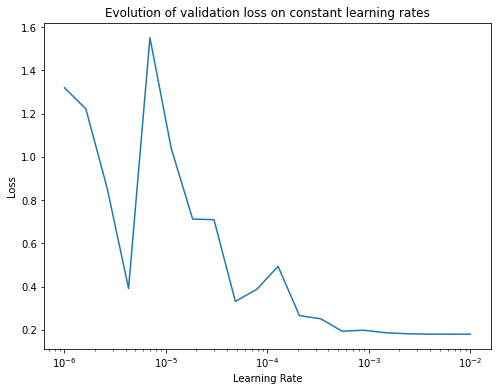

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(lrates, losses)
plt.title("Evolution of validation loss on constant learning rates")
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()

In [ ]:
W_gd1, b, history_gd1, vh1 = batch_gradient_descent(X,Y,10000,1, 0.1, fixed_seed=True, X_test=X_test, Y_test=Y_test)
W_gd2, b, history_gd2, vh2 = batch_gradient_descent(X,Y,10000,1, 0.01, fixed_seed=True, X_test=X_test, Y_test=Y_test)
W_gd3, b, history_gd3, vh3 = batch_gradient_descent(X,Y,10000,1, 0.001, fixed_seed=True, X_test=X_test, Y_test=Y_test)
W_gd4, b, history_gd4, vh4 = batch_gradient_descent(X,Y,10000,1, 0.0001, fixed_seed=True, X_test=X_test, Y_test=Y_test)

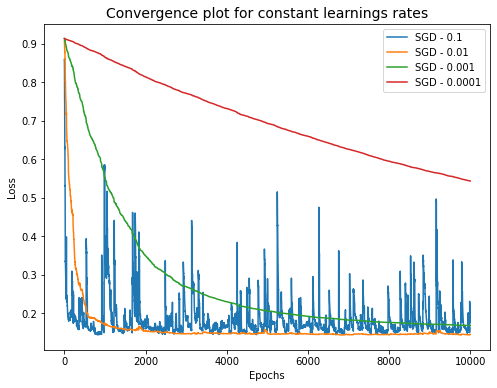

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Convergence plot for constant learnings rates", fontsize=14)
plt.plot(history_gd1, label="SGD - 0.1")
plt.plot(history_gd2, label="SGD - 0.01")
plt.plot(history_gd3, label="SGD - 0.001")
plt.plot(history_gd4, label="SGD - 0.0001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

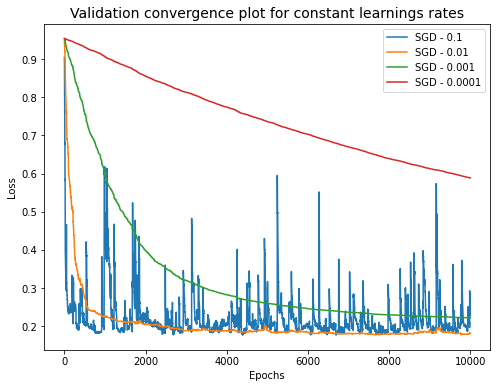

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Validation convergence plot for constant learnings rates", fontsize=14)
plt.plot(vh1, label="SGD - 0.1")
plt.plot(vh2, label="SGD - 0.01")
plt.plot(vh3, label="SGD - 0.001")
plt.plot(vh4, label="SGD - 0.0001")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Exploration of mini-batch size for SGD

In [89]:
lr = 0.001
W, b, history_b1, vhb1 = batch_gradient_descent(X,Y,10000,1, lr, X_test=X_test, Y_test=Y_test)
W, b, history_b5, vhb2 = batch_gradient_descent(X,Y,10000,5, lr, X_test=X_test, Y_test=Y_test)
W, b, history_b10, vhb3 = batch_gradient_descent(X,Y,10000,10, lr, X_test=X_test, Y_test=Y_test)
W, b, history_b25, vhb4 = batch_gradient_descent(X,Y,10000,25, lr, X_test=X_test, Y_test=Y_test)
W, b, history_b50, vhb5 = batch_gradient_descent(X,Y,10000,50, lr, X_test=X_test, Y_test=Y_test)

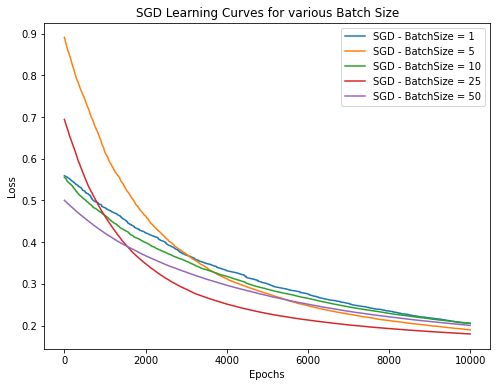

In [90]:
plt.figure(figsize=(8,6))
plt.title("SGD Learning Curves for various Batch Size")
plt.plot(history_b1, label="SGD - BatchSize = 1")
plt.plot(history_b5, label="SGD - BatchSize = 5")
plt.plot(history_b10, label="SGD - BatchSize = 10")
plt.plot(history_b25, label="SGD - BatchSize = 25")
plt.plot(history_b50, label="SGD - BatchSize = 50")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

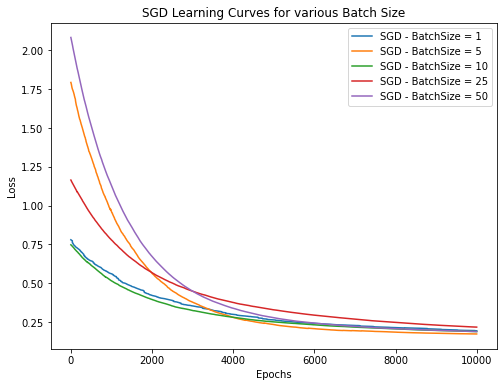

In [19]:
plt.figure(figsize=(8,6))
plt.title("SGD Learning Curves for various Batch Size")
plt.plot(vhb1, label="SGD - BatchSize = 1")
plt.plot(vhb2, label="SGD - BatchSize = 5")
plt.plot(vhb3, label="SGD - BatchSize = 10")
plt.plot(vhb4, label="SGD - BatchSize = 25")
plt.plot(vhb5, label="SGD - BatchSize = 50")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Convergence comparison

### Comparison of decreasing and constant learning rates



In [ ]:
lr = 0.001
W_sgd, b, history_sgd, val = batch_gradient_descent(X,Y,10000,1, lr, fixed_seed = True)
W_dsgd, b, history_dsgd, val = batch_gradient_descent(X,Y,10000,1, 0.2, stepChoice=0.5, fixed_seed = True)
W_bgd, b, history_bgd, val = batch_gradient_descent(X,Y,10000,X.shape[0], lr)
W_dbgd, b, history_dbgd, val= batch_gradient_descent(X,Y,10000,X.shape[0], 0.2, stepChoice=0.5)

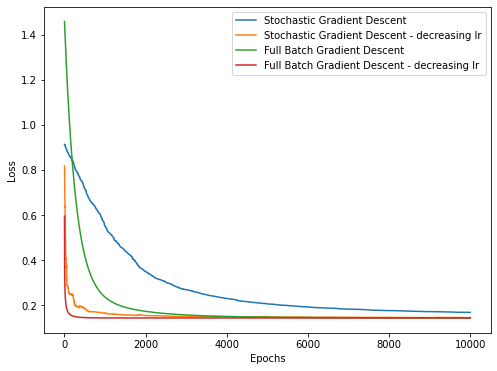

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history_sgd, label="Stochastic Gradient Descent")
plt.plot(history_dsgd, label="Stochastic Gradient Descent - decreasing lr")
plt.plot(history_bgd, label="Full Batch Gradient Descent")
plt.plot(history_dbgd, label="Full Batch Gradient Descent - decreasing lr")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Nesterov convergence comparison

In [ ]:
W, b, history, val = batch_gradient_descent(X, Y, 10000, X.shape[0], lr, gamma=0.9)
#W, b, history2 = batch_gradient_descent(X, Y, 5000, X.shape[0], lr)
W, b, history3, val = batch_gradient_descent(X, Y, 10000, 1, lr, 0, gamma=0.9)
#W, b, history4 = batch_gradient_descent(X, Y, 5000, 1, lr, 0, 0)

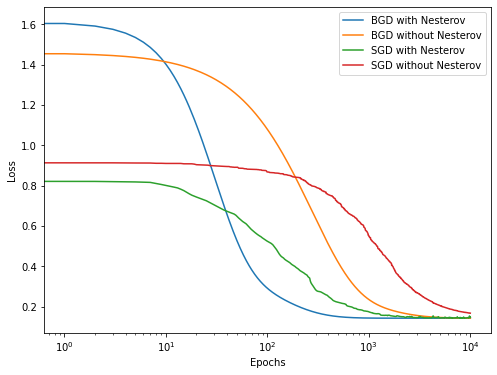

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history, label="BGD with Nesterov")
plt.plot(history_bgd, label="BGD without Nesterov")
plt.plot(history3, label="SGD with Nesterov")
plt.plot(history_sgd, label="SGD without Nesterov")
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Diagonal Scaling

In [ ]:
W, b, history, val = batch_gradient_descent(X, Y, epochs=10000, batchSize=1, alpha=lr)
W, b, history_rms, val = batch_gradient_descent(X, Y, epochs=10000, batchSize=1, alpha=lr, scaling=1)
W, b, history_adac, val = batch_gradient_descent(X, Y, epochs=10000, batchSize=1, alpha=lr, scaling=2)
W, b, history_adad, val = batch_gradient_descent(X, Y, epochs=10000, batchSize=1, alpha=lr, stepChoice=0.5, scaling=2)

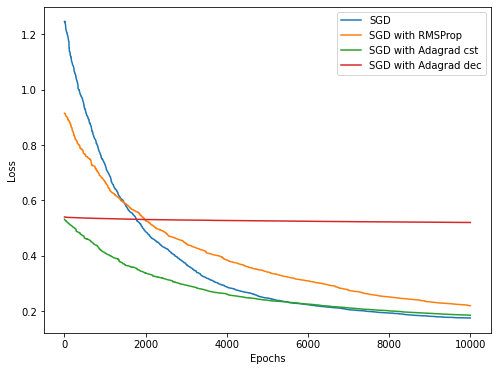

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history, label="SGD")
plt.plot(history_rms, label="SGD with RMSProp")
plt.plot(history_adac, label="SGD with Adagrad cst")
plt.plot(history_adad, label="SGD with Adagrad dec")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Regularization

In [ ]:
W, b, history_lasso5, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 0.1, fixed_seed=True)
W, b, history_lasso, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 1, fixed_seed=True)
W, b, history_lasso2, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 5, fixed_seed=True)
W, b, history_lasso3, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 10, fixed_seed=True)
W, b, history_lasso4, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 100, fixed_seed=True)
W, b, history_lasso6, val = batch_gradient_descent(X, Y, epochs=100, batchSize=1, alpha=lr, lbda = 1000, fixed_seed=True)

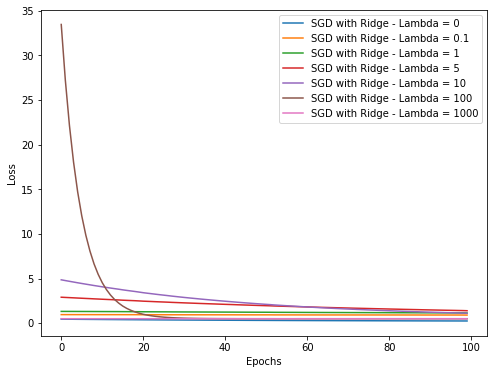

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history[:100], label="SGD with Ridge - Lambda = 0")
plt.plot(history_lasso5, label="SGD with Ridge - Lambda = 0.1")
plt.plot(history_lasso, label="SGD with Ridge - Lambda = 1")
plt.plot(history_lasso2, label="SGD with Ridge - Lambda = 5")
plt.plot(history_lasso3, label="SGD with Ridge - Lambda = 10")
plt.plot(history_lasso4, label="SGD with Ridge - Lambda = 100")
plt.plot(history_lasso6, label="SGD with Ridge - Lambda = 1000")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Optional Methods

### SVRG

In [35]:
W, b, history, val_hist = SVRG(X, Y, 10000, 0.001, 5, X_test, Y_test)
Wsgd, bsgd, history2, val = batch_gradient_descent(X, Y, 10000, 1, lr, 0, gamma=0.9, X_test=X_test, Y_test=Y_test)

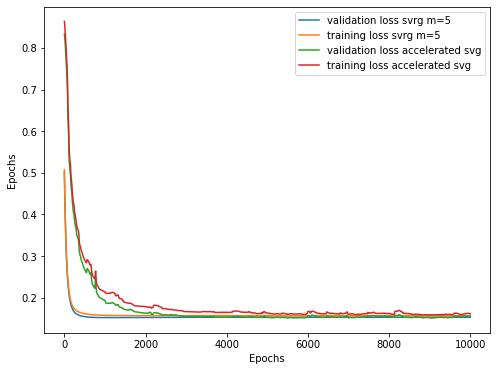

In [36]:
plt.figure(figsize=(8,6))
plt.plot(val_hist, label="validation loss svrg m=5")
plt.plot(history, label="training loss svrg m=5")
plt.plot(val, label="validation loss accelerated svg")
plt.plot(history2, label="training loss accelerated svg")
plt.xlabel("Epochs")
plt.ylabel("Epochs")
plt.legend()

In [38]:
W, b, history, val_hist = SVRG(X, Y, 2000, 0.001, 5, X_test, Y_test)
W, b, history2, val_hist2 = SVRG(X, Y, 2000, 0.001, 10, X_test, Y_test)
W, b, history3, val_hist3 = SVRG(X, Y, 2000, 0.001, 25, X_test, Y_test)
W, b, history4, val_hist4 = SVRG(X, Y, 2000, 0.001, 50, X_test, Y_test)
W, b, history5, val_hist5 = SVRG(X, Y, 2000, 0.001, 100, X_test, Y_test)

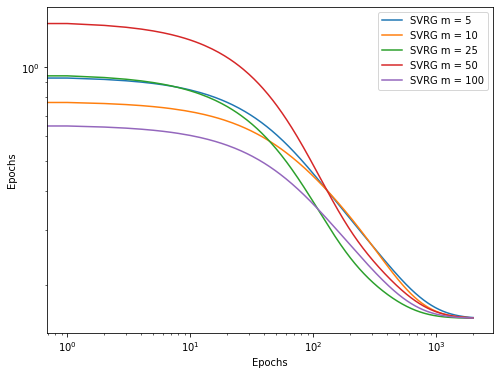

In [41]:
plt.figure(figsize=(8,6))
plt.plot(history, label="SVRG m = 5")
plt.plot(history2, label="SVRG m = 10")
plt.plot(history3, label="SVRG m = 25")
plt.plot(history4, label="SVRG m = 50")
plt.plot(history5, label="SVRG m = 100")
plt.xlabel("Epochs")
plt.ylabel("Epochs")
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Newton Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


[2.067393137930801, 3.3935897864703968, 0.5171007780635094, 1.5658405572013179, 3.5755088431684827, 1.3809389934578598, 0.9300228094123464, 0.2708691411341677, 0.5814682556708035, 5.3202774467451315]


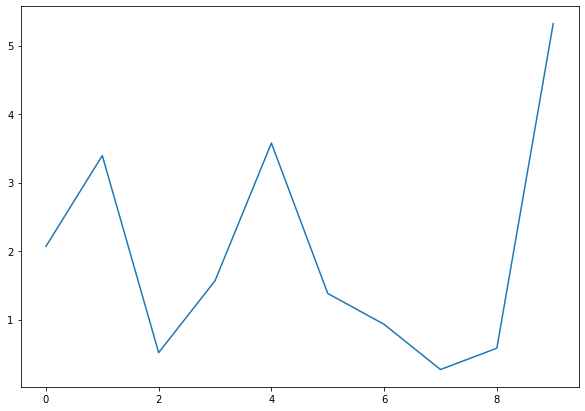

In [ ]:
W, b, history = newton_method(X, Y, 10) #Not Working
plt.plot(history)
print(history)

# Scikit Learn Values

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

sgdreg = SGDRegressor(max_iter=10000, learning_rate='constant', eta0 = 0.0003)
sgdreg.fit(X,Y)
print("SGDRegressor Training loss :", l2_loss(X, Y, sgdreg.coef_, sgdreg.intercept_, lbda=0))
print("SGDRegressor Validation loss :", l2_loss(X_test, Y_test, sgdreg.coef_, sgdreg.intercept_, lbda=0))

reg = LinearRegression().fit(X,Y)
print("LinearRegression Training loss :", l2_loss(X, Y, reg.coef_, reg.intercept_, lbda=0))
print("LinearRegression validation loss :", l2_loss(X_test, Y_test, reg.coef_, reg.intercept_, lbda=0))

W, b, history, val_hist = SVRG(X, Y, 2000, 0.001, 5, X_test, Y_test)
W2, b2, history, val_hist = batch_gradient_descent(X, Y, 10000, 1, lr, 0, gamma=0.9, X_test=X_test, Y_test=Y_test)

SGDRegressor Training loss : 0.15128082171297608
SGDRegressor Validation loss : 0.16821758076216434
LinearRegression Training loss : 0.15123047286059138
LinearRegression validation loss : 0.16793659564723282
